In [2]:
import pandas as pd
from dateutil.parser import parse
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import time
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from itertools import product
import warnings

In [3]:
df = pd.read_pickle('btcusdt_min_ohlcv_av_btcblock_Jan2019ToSep2021.pkl')

In [8]:
X = df[['BTCUSDT_high']]
y = df['BTCUSDT_volume']

In [3]:
#add year, day of month, day of month,week,year columns
df['year'] = pd.DatetimeIndex(df['close_time']).year
df['month'] = pd.DatetimeIndex(df['close_time']).month
df['date_of_month'] = pd.DatetimeIndex(df['close_time']).day
df['day_of_week'] = pd.DatetimeIndex(df['close_time']).dayofweek
df['day_of_year'] = pd.DatetimeIndex(df['close_time']).dayofyear
df['hour_of_day'] = pd.DatetimeIndex(df['close_time']).hour
df['hour_of_day'] = pd.DatetimeIndex(df['close_time']).minute

### Visual EDA

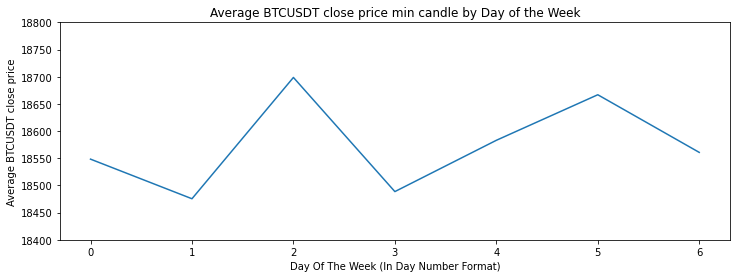

In [96]:
fig, axs = plt.subplots(figsize=(12, 4))

df.groupby([df["close_time"].dt.dayofweek])["BTCUSDT_close"].mean().plot(kind='line', ax=axs)
plt.title('Average BTCUSDT close price min candle by Day of the Week')
plt.xlabel("Day Of The Week (In Day Number Format)");  # custom x label using matplotlib
plt.ylabel("Average BTCUSDT close price")
plt.ylim(ymin=18400, ymax=18800)
plt.draw()

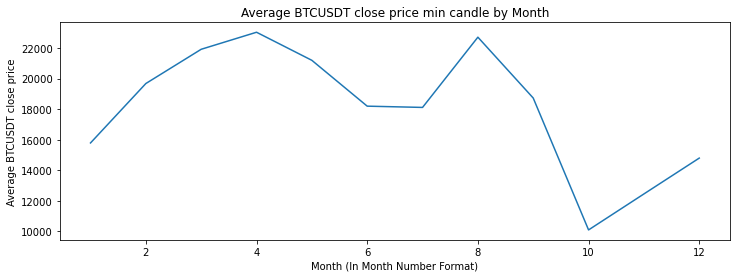

In [95]:
fig, axs = plt.subplots(figsize=(12, 4))

df.groupby([df["close_time"].dt.month])["BTCUSDT_close"].mean().plot(kind='line', ax=axs)
plt.title('Average BTCUSDT close price min candle by Month')
plt.xlabel("Month (In Month Number Format)");  # custom x label using matplotlib
plt.ylabel("Average BTCUSDT close price")
#plt.ylim(ymin=18200, ymax=18800)
plt.draw()

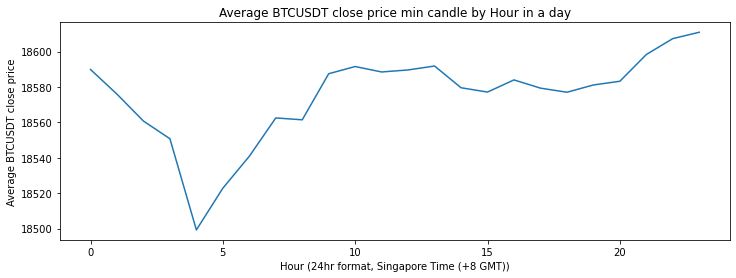

In [94]:
#df.groupby(df.close_time.dt.hour).BTCUSDT_close.mean()
fig, axs = plt.subplots(figsize=(12, 4))

df.groupby(df.close_time.dt.hour).BTCUSDT_close.mean().plot(kind='line', ax=axs)
plt.title('Average BTCUSDT close price min candle by Hour in a day')
plt.xlabel("Hour (24hr format, Singapore Time (+8 GMT))");  # custom x label using matplotlib
plt.ylabel("Average BTCUSDT close price")
#plt.ylim(ymin=18200, ymax=18800)
plt.draw()

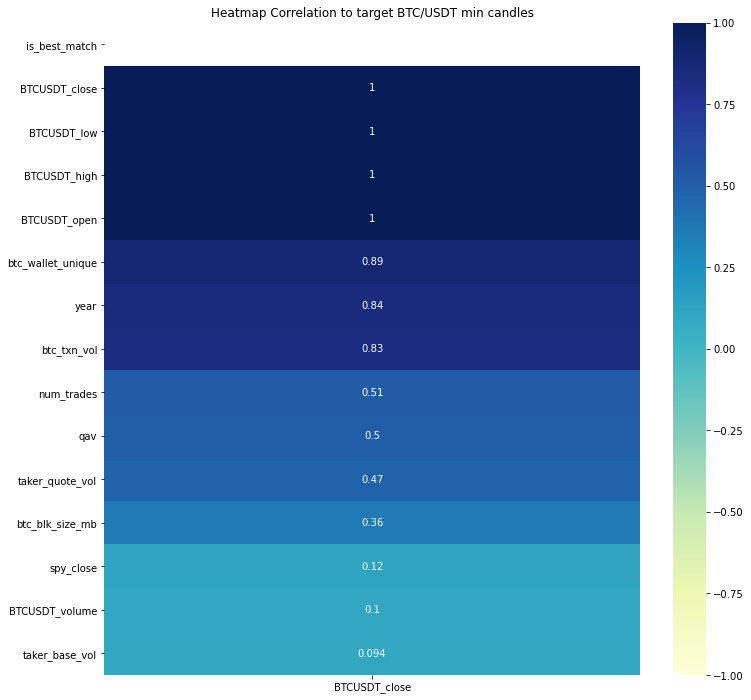

In [31]:
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(df.corr()[['BTCUSDT_close']].sort_values('BTCUSDT_close').tail(15),
 vmax=1, vmin=-1, cmap='YlGnBu', annot=True, ax=ax);
ax.set_title('Heatmap Correlation to target BTC/USDT min candles')
ax.invert_yaxis()

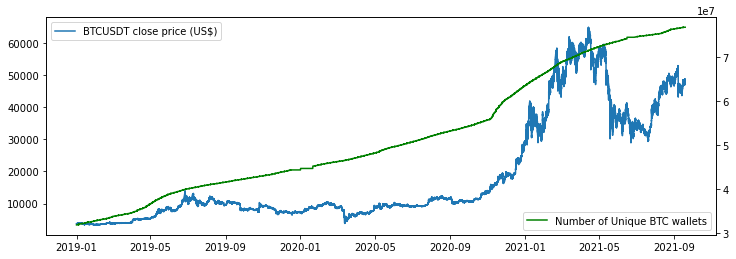

In [113]:
fig, ax= plt.subplots(figsize=(12, 4))
ax1=plt.subplot(111)
ax1.plot(df['close_time'], df['BTCUSDT_close'], label='BTCUSDT close price (US$)')
ax2=ax1.twinx()
ax2.plot(df['close_time'],df['btc_wallet_unique'],'g-', label='Number of Unique BTC wallets')
ax1.legend()
ax2.legend(loc=4)

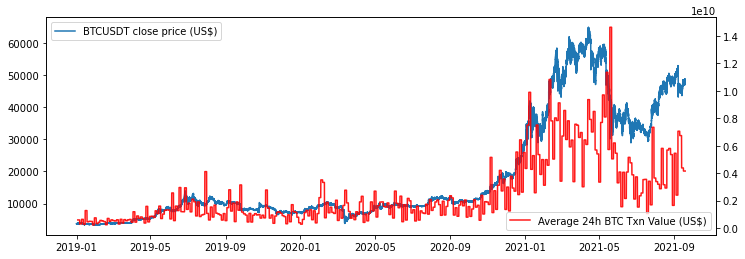

In [116]:
fig, ax= plt.subplots(figsize=(12, 4))
ax1=plt.subplot(111)
ax1.plot(df['close_time'], df['BTCUSDT_close'], label='BTCUSDT close price (US$)')
ax2=ax1.twinx()
ax2.plot(df['close_time'],df['btc_txn_vol'],'r-', label='Average 24h BTC Txn Value (US$)', alpha=0.9)
ax1.legend()
ax2.legend(loc=4)

In [23]:
df

1457737   -1150.30
1457738     629.07
1457739     -56.41
1457740     -80.84
1457741     -78.83
            ...   
1699446      64.85
1699447      43.23
1699448    -237.05
1699449     299.49
1699450    -196.36
Name: rolling_daily_return, Length: 241714, dtype: float64

### Computing the difference in daily returns and plotting it

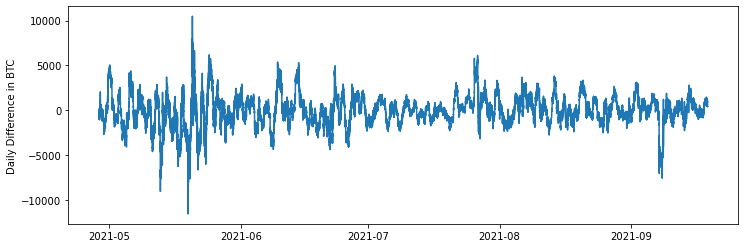

In [7]:
# Need to difference
fig, ax= plt.subplots(figsize=(12, 4))
ax1=plt.subplot(111)
df['rolling_daily_return'] = df.BTCUSDT_high.diff(periods=(60*24)) #we are using minute candles here,
df.rolling_daily_return.dropna(inplace=True)
ax.plot(df['close_time'],df['rolling_daily_return'])
ax.set_ylabel("Daily Difference in BTC")
plt.show()

In [8]:
df['rolling_daily_return']

1450533       NaN
1450534       NaN
1450535       NaN
1450536       NaN
1450537       NaN
            ...  
1699446    400.74
1699447    459.44
1699448    427.28
1699449    431.93
1699450    404.70
Name: rolling_daily_return, Length: 248918, dtype: float64

## Applying an ADF test to the differenced data 

In [9]:
df.dropna(how='any',inplace=True)
df['rolling_daily_return'].isnull().values.any()

False

In [10]:
result = adfuller(df['rolling_daily_return'])
pvalue = result[1]
if pvalue < 0.05:
    print('stationary')
else:
    print('not stationary')

stationary


Stationary time series is when the mean and variance are constant over time. It is easier to predict when the series is stationary. We should therefore be able to predict daily returns with MA/ARIMA quite easily with a univariate model

https://towardsdatascience.com/time-series-forecasting-arima-models-7f221e9eee06

In [13]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

If we fail to reject the null hypothesis, we can say that the series is non-stationary. This means that the series can be linear or difference stationary.

If both mean and standard deviation are flat lines(constant mean and constant variance), the series becomes stationary.

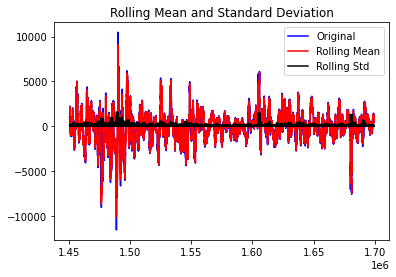

Results of dickey fuller test
Test Statistics               -1.001683e+01
p-value                        1.719984e-17
No. of lags used               8.500000e+01
Number of observations used    2.488320e+05
critical value (1%)           -3.430376e+00
critical value (5%)           -2.861552e+00
critical value (10%)          -2.566776e+00
dtype: float64


In [16]:
test_stationarity(df['rolling_daily_return'])

### Plotting the Autocorrelation Function and the Partial Autocorrelation Function

The Autocorrelation function plot will let you know how the given time series is correlated with itself

If there is a Positive autocorrelation at lag 1 then we use the AR model

If there is a Negative autocorrelation at lag 1 then we use the MA model


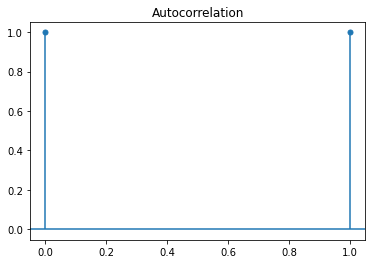

In [11]:
plot_acf(df['rolling_daily_return'], lags=1)
plt.show()

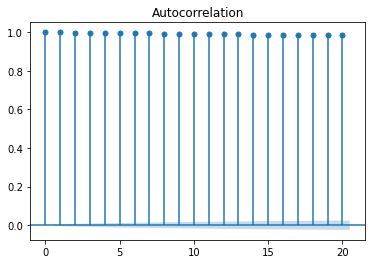

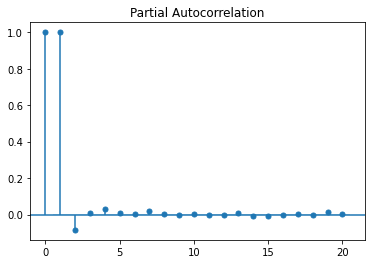

In [12]:
plot_acf(df['rolling_daily_return'], lags=20)
plot_pacf(df['rolling_daily_return'], lags=20)
plt.show()

### Seasonal Decompose

In order to perform a time series analysis, we may need to separate seasonality and trend from our series. The resultant series will become stationary through this process.

So let us separate Trend and Seasonality from the time series.

/var/folders/j5/x7jwjkqx43nb9p2pjd5tnwvm0000gn/T/ipykernel_13985/1643796191.py:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  result = seasonal_decompose(df['BTCUSDT_high'], model='additive', freq=28)


<Figure size 432x288 with 0 Axes>

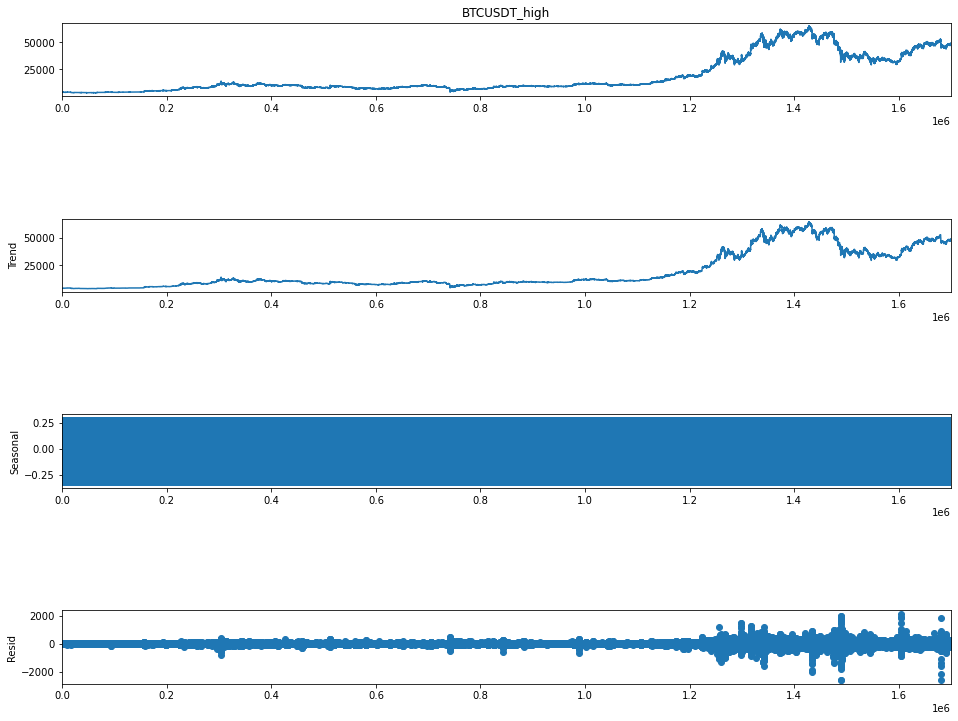

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose
#frequency of 28 as we want to explor the relatiionship for monthly btc option expiries
result = seasonal_decompose(df['BTCUSDT_high'], model='additive', freq=28) 

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 12)

we start by taking a log of the series to reduce the magnitude of the values and reduce the rising trend in the series. Then after getting the log of the series, we find the rolling average of the series. A rolling average is calculated by taking input for the past 1 months (60*24*28) and giving a mean consumption value at every point further ahead in series.

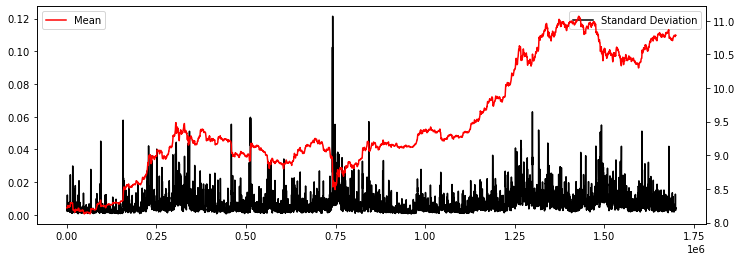

In [4]:
df_log = np.log(df.BTCUSDT_high)
moving_avg = df_log.rolling(60*12).mean()
std_dev = df_log.rolling(60*12).std()

fig, ax= plt.subplots(figsize=(12, 4))
ax1=plt.subplot(111)
ax1.plot(std_dev, color ="black", label = "Standard Deviation")
ax2=ax1.twinx()
ax2.plot(moving_avg, color="red", label = "Mean")
ax1.legend(loc='best')
ax2.legend(loc=2)

No handles with labels found to put in legend.


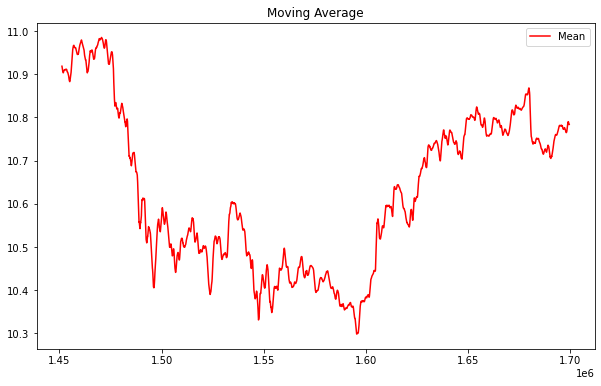

In [6]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df.BTCUSDT_high)
moving_avg = df_log.rolling(60*12).mean()
std_dev = df_log.rolling(60*12).std()
plt.legend(loc='best')
plt.title('Moving Average')
#plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

### ARIMA 

https://www.kdnuggets.com/2020/01/stock-market-forecasting-time-series-analysis.html

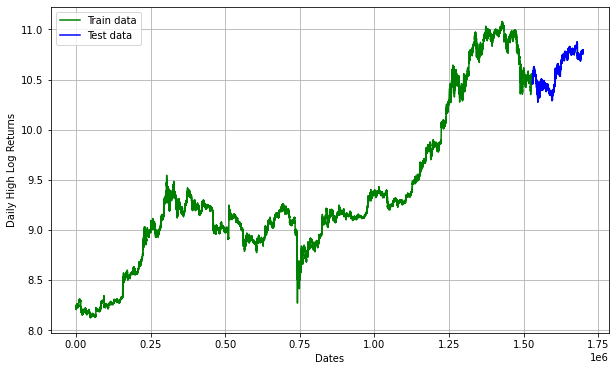

In [11]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Daily High Log Returns')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

/Users/lawrenceyim/opt/miniconda3/envs/binance_eda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/lawrenceyim/opt/miniconda3/envs/binance_eda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/lawrenceyim/opt/miniconda3/envs/binance_eda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


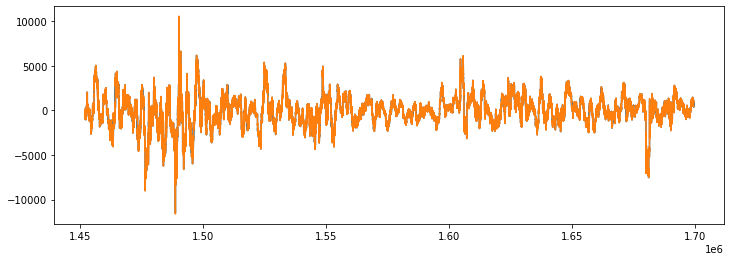

r2 score is:  0.9984112175225354
MSE is:  4200.673336301357
RMSE is:  4200.673336301357
MAE is:  38.28134894250116
MAPE is:  3828874697026.8457


In [22]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

from statsmodels.tsa.arima.model import ARIMA

fig, ax= plt.subplots(figsize=(12, 4))
# Forecast the first MA(1) model
mod = ARIMA(df['rolling_daily_return'], order=(3,1,3)) #used pqd from arima walkforward validation
res = mod.fit()

orig_data = df['rolling_daily_return'].dropna()
pred = res.predict()

plt.plot(orig_data, label='Original Data')
plt.plot(pred, label='Predictions')
plt.show()

print('r2 score is: ',r2_score(orig_data, pred))
print('MSE is: ',mean_squared_error(orig_data, pred))
print('RMSE is: ',np.sqrt(mean_squared_error(orig_data, pred)))
print('MAE is: ',mean_absolute_error(orig_data, pred))
print('MAPE is: ',mean_absolute_percentage_error(orig_data, pred))

In [23]:
print('RMSE is: ',np.sqrt(mean_squared_error(orig_data, pred)))

RMSE is:  64.8126016782335


r2 of 99.8 is very ideal

### ARIMA walkforward validation

We will do a walk forward validation to find optimal pqd for the ARIMA model

In [ ]:
from pmdarima.arima import auto_arima

In [37]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2391131.497, Time=34.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2392910.778, Time=56.96 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2392938.497, Time=43.87 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2391133.465, Time=14.18 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2392937.072, Time=50.49 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-2392936.632, Time=58.59 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2392989.524, Time=87.68 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-2393103.107, Time=98.46 sec


/Users/lawrenceyim/opt/miniconda3/envs/binance_eda/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/lawrenceyim/opt/miniconda3/envs/binance_eda/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1897: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-2391117.388, Time=79.99 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-2391112.428, Time=118.10 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-2393136.732, Time=115.26 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-2393116.064, Time=97.30 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-2393144.520, Time=128.96 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=-2393146.107, Time=81.89 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=-2393138.060, Time=56.49 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=-2392993.992, Time=50.84 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-2393104.456, Time=74.31 sec

Best model:  ARIMA(3,1,3)(0,0,0)[0]          
Total fit time: 1249.229 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:               224023
Model:               SARIMAX(3, 1, 3)   Log Likelihood             1196580.053
Date:                Mon, 27 Sep 2021   A

The Auto ARIMA model provided the value of pdq as follows
- P: 3
- D: 1
- Q: 3

/Users/lawrenceyim/opt/miniconda3/envs/binance_eda/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


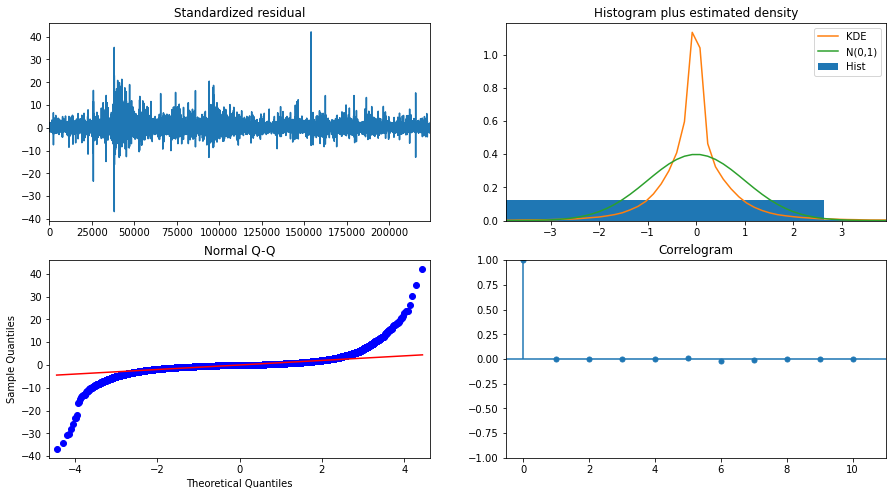

In [38]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

Top left: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

Top Right: The density plot suggest normal distribution with mean zero.

Bottom left: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

Bottom Right: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.

Overall, it seems to be a good fit. Let’s start forecasting the bitcoin prices.

In [8]:
from statsmodels.tsa.arima_model import ARIMA

In [14]:
model = ARIMA(train_data, order=(3, 1, 3))  

/Users/lawrenceyim/opt/miniconda3/envs/binance_eda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/lawrenceyim/opt/miniconda3/envs/binance_eda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/lawrenceyim/opt/miniconda3/envs/binance_eda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


In [15]:
fitted = model.fit()  

In [16]:
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:           BTCUSDT_high   No. Observations:              1529502
Model:                 ARIMA(3, 1, 3)   Log Likelihood             8487522.631
Date:                Mon, 27 Sep 2021   AIC                      -16975031.262
Time:                        18:06:56   BIC                      -16974945.579
Sample:                             0   HQIC                     -16975008.077
                            - 1529502                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0525    6.6e-05   -796.484      0.000      -0.053      -0.052
ar.L2          0.2764      0.000   1983.360      0.000       0.276       0.277
ar.L3         -0.1218      0.001   -122.664      0.0